# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /Users/leonardoigler/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [4]:
eth_vtol_param["gravity"] = 0;#9.81;

In [5]:
DESIRED_x = [-4.0, 0.0, 4.0] # desired distance    
angle = -pi/8.0 # 
DESIRED_R = Matrix(UnitQuaternion(RotY(angle)*RotX(pi/2.0)*RotZ(pi/2.0)))

create_VTOL("fixgoal", actuators = false, color_vec=[1.0; 0.0; 0.0; 1.0]);
set_transform("fixgoal", DESIRED_x ,QuatRotation(DESIRED_R)); 

# Create Reinforcement Learning Environment

In [6]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A
    observation_space::Space{Vector{ClosedInterval{T}}}
    state::Vector{T}
    action::ACT
    done::Bool
    t::T # time
    rng::R

    name::String #for multible environoments
    visualization::Bool
    realtime::Bool
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T}
    v_B::Vector{T}
    R_W::Matrix{T}
    ω_B::Vector{T}
    wind_W::Vector{T}
    Δt::T
    
    # Bonus / Target
    x_d_W::Vector{T}
    R_d_W::Matrix{T}
    covered_line::T
    previously_covered_line::T
end

In [7]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
     
    #continuous = true,
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    #action_space = Base.OneTo(21) # 21 discrete positions for the flaps
    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            
            # If you are not flying horizontally, you can later switch gravitation 
            # back on and counteract it with the rotors as well.
            # In addition, once the drone has flown over its target, 
            # it can "fall down" and does not have to turn around.
            
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along y
            typemin(T)..typemax(T), # orientation along x: REALLY NEEDED?
            typemin(T)..typemax(T), # orientation along z
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x
            typemin(T)..typemax(T), # position error along y: CHANGED TO Y
            # Not used in Paper!!!
            typemin(T)..typemax(T), # target rotation along x (better than angle for neural networks)
            typemin(T)..typemax(T), # target rotation along z (better than angle for neural networks)
            typemin(T)..typemax(T), # The distance along the connecting line which has been covered
            typemin(T)..typemax(T), # The distance along the connecting line which has been previously covered
            
            ], 
    )

    # Calculate random vector & angle

    #################################
    
    if visualization
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, 10), # current state, needs to be extended. 
        rand(action_space),
        false, # episode done ?
        0.0, # time
        rng, # random number generator  
        name,
        visualization,
        realtime,
        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        #Matrix(UnitQuaternion((RotX(pi)))),
        [1.0 0.0 0.0; 0.0 -1.0 0.0; 0.0 0.0 -1.0], # R_W Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        # TODO Random
        DESIRED_x, # desired distance 
        DESIRED_R, # desired orientation
        0.0,
        0.0,
    )
    
    
    reset!(environment)
    
    return environment
    
end;

ErrorException: syntax: missing comma or ) in argument list

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [8]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/2d/rl_continuous_2d.ipynb:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, x_d_W::Vector{T}, R_d_W::Matrix{T}, covered_line::T, previously_covered_line::T) where {A, T, ACT, R<:AbstractRNG} in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/2d/rl_continuous_2d.ipynb:2

# Define the RL interface

In [9]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [10]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
        
    distance_goal = exp(-sum((env.x_W - env.x_d_W).^2)/10)*10
    
    limit_rotation = abs(env.ω_B[3])*100

    progress = ((env.covered_line-norm(env.x_d_W))^2)#exp((-(env.covered_line-norm(env.x_d_W))^2)/10)*100
    
    new_progress = (env.covered_line-env.previously_covered_line)

    # TODO: Make yourself comfortable with what this is
    difference_angle = exp(-sum((env.R_W[:,1] - env.R_d_W[:,1]).^2))#*10.0 #0 was good
    
    #    difference_angle = exp(-sum(((env.R_W[:,1] - env.R_d_W[:,1]).^2)))*10#*10.0 #0 was good
      
    #print("\ncovered: \n")
    #print(env.covered_line)
    #print("\nnew: \n")
    #print(env.previously_covered_line)
    #print("\n")
    #print("\n")

    #env.previously_covered_line = env.covered_line

    #print("distance_goal: \n")
    #print(distance_goal)
    #print("\nlimit_rotation: \n")
    #print(limit_rotation)
    #print("\nprogress: \n")
    #print(progress)
    #print("\nnew_progress: \n")
    #print(new_progress)
    #print("\ndifference_angle: \n")
    #print(difference_angle)
    #print("\n")
    #print("\n")

    return progress + new_progress + distance_goal - limit_rotation - difference_angle
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [11]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0])
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotX(pi)))#Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));
    #env.R_W = Matrix(UnitQuaternion(RotX(pi)));
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.x_d_W = [rand(Uniform(0,10)), rand(Uniform(-10,10)), 0.0]
    #env.angle_d_W = calculateAngle([1.0 ,0.0, 0.0], env.x_d_W) # desired angle
    #x_vec = [1.0; 0.0; 0.0]
    #env.angle_d_W = calculateAngle(x_vec, env.x_d_W) # Should the drone arrive at the target like this or is there another idea behind it?
    angle = calculateAngle([1.0 ,0.0, 0.0], env.x_d_W)
    env.R_d_W = Matrix(UnitQuaternion(RotZ(angle)*RotX(pi)))

    env.covered_line = 0.0
    env.previously_covered_line = 0.0
    
    if env.visualization
        create_VTOL("fixgoal", actuators = false, color_vec=[1.0; 0.0; 0.0; 1.0]);
        set_transform("fixgoal", env.x_d_W ,QuatRotation(env.R_d_W)); 
    end

    env.state = [env.x_W[1];
                 env.x_W[2];
                 env.R_W[1,1];
                 env.R_W[3,1];
                 env.v_B[1];
                 env.v_B[2];
                 env.ω_B[3];
                 env.x_W[1] - env.x_d_W[1];
                 env.x_W[2] - env.x_d_W[2]; # CHANGED TO Y
                 env.R_d_W[1,1];
                 env.R_d_W[3,1];
                 env.covered_line;
                 env.previously_covered_line] 
    
    env.t = 0.0
    env.action = [0.0, 0.0]
    env.done = false
    nothing

end;

In [12]:
R_W = Matrix(UnitQuaternion(RotX(pi)))
Rotations.params(RotYXZ(R_W))


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 3.141592653589793
 1.2246467991473532e-16
 3.141592653589793

In [13]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)

    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [14]:
env = VtolEnv();

MethodError: MethodError: no method matching VtolEnv()
Closest candidates are:
  VtolEnv(!Matched::A, !Matched::Space{Array{ClosedInterval{T}, 1}}, !Matched::Vector{T}, !Matched::ACT, !Matched::Bool, !Matched::T, !Matched::R, !Matched::String, !Matched::Bool, !Matched::Bool, !Matched::Vector{T}, !Matched::Vector{T}, !Matched::Matrix{T}, !Matched::Vector{T}, !Matched::Vector{T}, !Matched::T, !Matched::Vector{T}, !Matched::Matrix{T}) where {A, T, ACT, R<:AbstractRNG} at ~/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/rl_continuous_2d.ipynb:2

In [15]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/2d/rl_continuous_2d.ipynb:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [16]:
function _step!(env::VtolEnv, next_action)
    
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    env.covered_line = dot(env.x_W, env.x_d_W)/(norm(env.x_d_W))
    
    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
    end
 
    env.t += env.Δt
    
    # State space
    #rot = Rotations.params(RotYXZ(env.R_W))[3]
    #env.state[1] = env.x_W[1] # world position in x
    #env.state[2] = env.ω_B[2] # world position in y
    #env.state[3] = rot # rotation around z
    #rot = Rotations.params(RotYXZ(env.R_W))[1]
    
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[2];  # position along y
    env.state[3] = env.R_W[1,1];    # orientation along x
    env.state[4] = env.R_W[3,1];   # orientation along z
    env.state[5] = env.v_B[1];  # velocity along x BODY coordinates
    env.state[6] = env.v_B[2];  # velocity along y BODY coordinates
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    env.state[8] = env.x_W[1] - env.x_d_W[1];   # position error along x
    env.state[9] = env.x_W[2] - env.x_d_W[2];   # position error along y
    env.state[10] = env.R_d_W[1,1];  # target rotation along x (better than angle for neural networks)
    env.state[11] = env.R_d_W[3,1];    # target orientation along z
    env.state[12] = env.covered_line    # Covered distance along line after step
    env.state[13] = env.previously_covered_line # Covered distance along line before step
    
    #print("\nSTEP: \n")
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true

        # TODO Zu lang
        # TODO Zu weit weg
        # TODO Ziel erreicht

        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 50.0 || 
        norm(env.v_B) > 50.0 || # stop if body is too fast
        #env.x_W[3] < -10.0 || # stop if body is below -10m
        #0.0 > rot || # Stop if the drone is pitched 90°.
        #rot > pi || # Stop if the drone is pitched 90°.
        sum((env.x_W - env.x_d_W).^2) < 0.1 ||
        #sum((env.x_W - env.x_d_W).^2) > 5000.0||
        env.t > 5.0 # stop after 10s
    nothing
end;

In [17]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  

Total  Time


random policy with VtolEnv | 2000   2000  1.0s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.668955599929278e9, 1.668955600879571e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [18]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [19]:
# Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),#
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

UndefVarError: UndefVarError: env not defined

In [20]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /Users/leonardoigler/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [21]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models/", "vtol_2D_ppo_$t.bson")
    @save f model
    println("parameters at step $t saved to $f")
end;

In [22]:
function loadModel()
    f = joinpath("./RL_models/", "vtol_2D_ppo_3100000.bson")
    @load f model
    return model
end;

In [23]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(mean(episode_test_reward_hook.rewards))")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

MethodError: MethodError: no method matching VtolEnv(; name="testVTOL", visualization=true, realtime=true)
Closest candidates are:
  VtolEnv(!Matched::A, !Matched::Space{Array{ClosedInterval{T}, 1}}, !Matched::Vector{T}, !Matched::ACT, !Matched::Bool, !Matched::T, !Matched::R, !Matched::String, !Matched::Bool, !Matched::Bool, !Matched::Vector{T}, !Matched::Vector{T}, !Matched::Matrix{T}, !Matched::Vector{T}, !Matched::Vector{T}, !Matched::T, !Matched::Vector{T}, !Matched::Matrix{T}) where {A, T, ACT, R<:AbstractRNG} at ~/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/rl_continuous_2d.ipynb:2 got unsupported keyword arguments "name", "visualization", "realtime"

In [24]:
#agent.policy.approximator = loadModel();

In [25]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(4_000_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)


Progress:   0%|                                         |  ETA: 86.61 days

Progress:   0%|                                         |  ETA: 1 days, 1:58:37

Progress:   0%|                                         |  ETA: 6:08:50

Progress:   0%|▏                                        |  ETA: 3:35:38

test reward at step 10000: 111414.58706855947


Progress:   0%|▏                                        |  ETA: 3:02:37

Progress:   0%|▏                                        |  ETA: 2:16:33

Progress:   0%|▎                                        |  ETA: 1:54:37

test reward at step 20000: 70588.29062479075


Progress:   1%|▎                                        |  ETA: 1:42:48

Progress:   1%|▎                                        |  ETA: 1:30:58

test reward at step 30000: 110053.61048470436


Progress:   1%|▍                                        |  ETA: 1:34:45

Progress:   1%|▍                                        |  ETA: 1:27:28

Progress:   1%|▍                                        |  ETA: 1:21:38

test reward at step 40000: 111591.13809225392


Progress:   1%|▍                                        |  ETA: 1:26:03

Progress:   1%|▌                                        |  ETA: 1:18:54

Progress:   1%|▌                                        |  ETA: 1:14:51

test reward at step 50000: 112266.14844621325


Progress:   1%|▌                                        |  ETA: 1:19:05

Progress:   1%|▋                                        |  ETA: 1:15:07

Progress:   1%|▋                                        |  ETA: 1:12:00

test reward at step 60000: 109785.56833234635


Progress:   2%|▋                                        |  ETA: 1:13:12

Progress:   2%|▋                                        |  ETA: 1:10:23

Progress:   2%|▊                                        |  ETA: 1:08:18

test reward at step 70000: 112132.6294449121


Progress:   2%|▊                                        |  ETA: 1:11:53

Progress:   2%|▊                                        |  ETA: 1:09:25

Progress:   2%|▊                                        |  ETA: 1:07:00

test reward at step 80000: 101080.49326664746


Progress:   2%|▉                                        |  ETA: 1:09:32

Progress:   2%|▉                                        |  ETA: 1:07:56

Progress:   2%|▉                                        |  ETA: 1:06:24

test reward at step 90000: 96301.88170558165


Progress:   2%|▉                                        |  ETA: 1:08:51

Progress:   2%|█                                        |  ETA: 1:06:53

Progress:   2%|█                                        |  ETA: 1:05:22

parameters at step 100000 saved to ./RL_models/vtol_2D_ppo_100000.bson


test reward at step 100000: 86896.40062899246


Progress:   3%|█                                        |  ETA: 1:06:47

Progress:   3%|█▏                                       |  ETA: 1:04:57

Progress:   3%|█▏                                       |  ETA: 1:03:55

test reward at step 110000: 80688.50961556958


Progress:   3%|█▏                                       |  ETA: 1:04:03

Progress:   3%|█▏                                       |  ETA: 1:02:50

Progress:   3%|█▎                                       |  ETA: 1:01:40

Progress:   3%|█▎                                       |  ETA: 1:00:36

test reward at step 120000: 75748.80065259725


Progress:   3%|█▎                                       |  ETA: 1:00:04

Progress:   3%|█▎                                       |  ETA: 0:59:01

Progress:   3%|█▍                                       |  ETA: 0:57:59

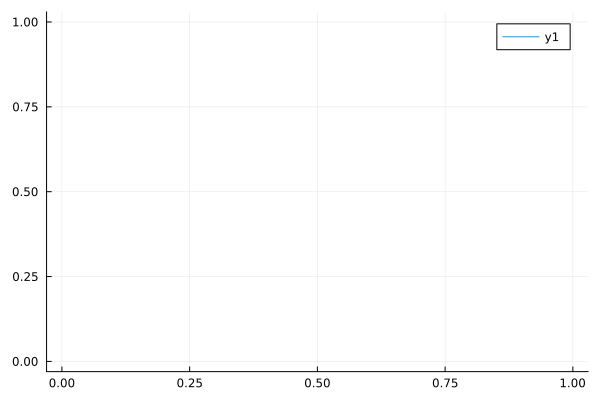

In [21]:
plot(episode_test_reward_hook.rewards)

In [ ]:
close_visualization(); # closes the MeshCat visualization